In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import shutil

from torchinfo import summary
import torch.utils.tensorboard as tb

import models_pheno
import models_decode
import models_breed
import mnist
import neuroevolution
import coevolve_ne
import ordinary_ne

torch.manual_seed(10);
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_idx = 0

In [3]:
# import tempfile
# tb_log_dir = tempfile.mkdtemp()
user = os.getlogin()
# tb_log_dir = os.path.join(cp.data_dir, 'tensorboard/', user)
tb_log_dir = f'/tmp/tensorboard/{user}'
# print(tb_log_dir)
    

In [4]:
logger = tb.SummaryWriter(tb_log_dir, flush_secs=5)

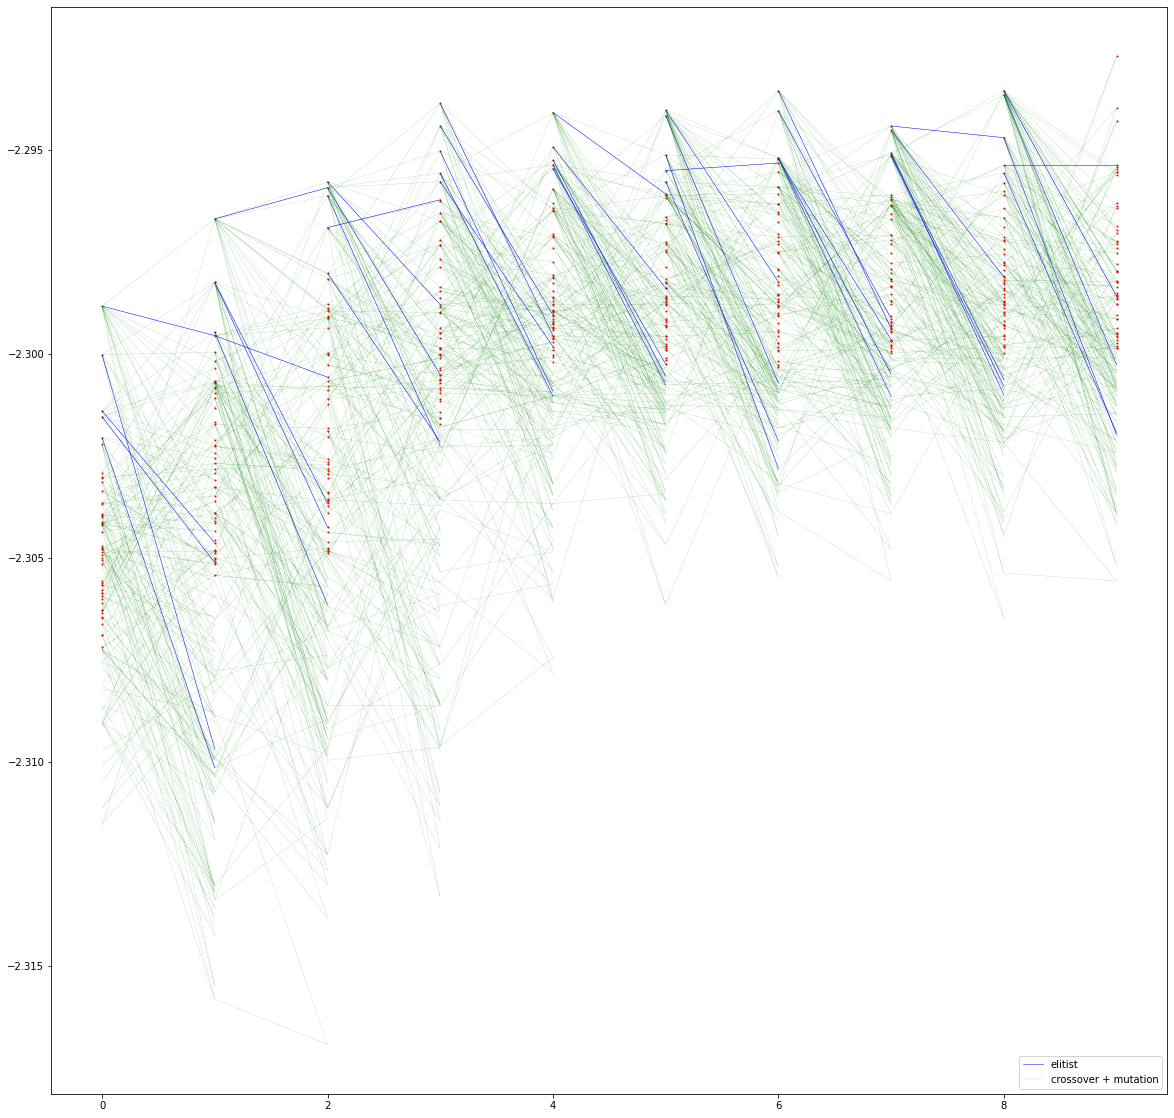

In [6]:
plt.figure(figsize=(20,20))
for gen_idx in range(10):
#     pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
    fitnesses = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx:05d}'))
#     fitnesses = np.arange(100)[::-1]
    plt.scatter(np.full_like(fitnesses, gen_idx)[:50], fitnesses[:50], c='r', s=1)
    if gen_idx>0:
        fitnesses_prev = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx-1:05d}'))
#         fitnesses_prev = np.arange(100)[::-1]
        parents_idxs = torch.load(os.path.join(logger.log_dir, f'parent_idxs_gen_{gen_idx:05d}'))
        for i, p_idx in enumerate(parents_idxs):
            if p_idx.size==1:
                pass
                clone = plt.plot([gen_idx, gen_idx-1], [fitnesses[i], fitnesses_prev[p_idx]], c='b', linewidth=0.5)
            else:
                pass
                cross = plt.plot([gen_idx-1, gen_idx, gen_idx-1], 
                                 [fitnesses_prev[p_idx[0]], fitnesses[i], fitnesses_prev[p_idx[1]]], c='g', linewidth=0.1)
plt.legend([clone[0], cross[0]], ['elitist', 'crossover + mutation'], loc='lower right')
plt.show()
            


In [103]:
X_train, Y_train = [], []
for X_batch, Y_batch in tqdm(mnist.train_loader):
    X_train.append(X_batch)
    Y_train.append(Y_batch)

In [104]:
batch_idx = 0
def calc_pheo_fitness(net):
    global batch_idx
#     batch_idx, (X_batch, Y_batch) = next(enumerate(mnist.train_loader))
    X_batch, Y_batch = X_train[batch_idx].to(device), Y_train[batch_idx].to(device)
#     batch_idx = (batch_idx+1)%len(X_train)
    
    Y_batch_pred = net(X_batch)
    n_correct = (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
    loss = mnist.loss_func(Y_batch_pred.log(), Y_batch).item()
#     if not np.isfinite(loss):
#         loss = 10.
    accuracy = n_correct/len(Y_batch)
    
    return {'fitness': -loss, 'loss': loss, 'accuracy': accuracy}

In [232]:
gen_idx = 999
# plt.figure(figsize=(20,20))
config = torch.load(os.path.join(logger.log_dir, 'config'))
pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
fitnesses = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx:05d}'))

In [233]:
decoder = models_decode.LinearDecoder(config)
pheno = models_pheno.SmallNet(config)
pheno = pop[0].to_pheno(decoder=decoder, pheno=pheno)

In [234]:
calc_pheo_fitness(pheno)

{'fitness': -1.012883186340332, 'loss': 1.012883186340332, 'accuracy': 0.679}

In [235]:
decoder = models_decode.LinearDecoder(config)
pheno = models_pheno.SmallNet(config)

fit = np.zeros((len(pop), len(pop)))

def to_pheno_mix_match_dna_and_decoder(geno1, geno2, decoder, pheno):
    decoder.load_decoder_dna(geno1.decoder_dna)
    pheno_dna = decoder.decode_dna(geno2.dna)
    pheno.load_pheno_dna(pheno_dna)
    return pheno
    
for i, geno1 in tqdm(enumerate(pop), total=len(pop)):
    for j, geno2 in enumerate(pop):
        pheno = to_pheno_mix_match_dna_and_decoder(geno1, geno2, decoder, pheno)
        fit[i, j] = calc_pheo_fitness(pheno)['fitness']
        

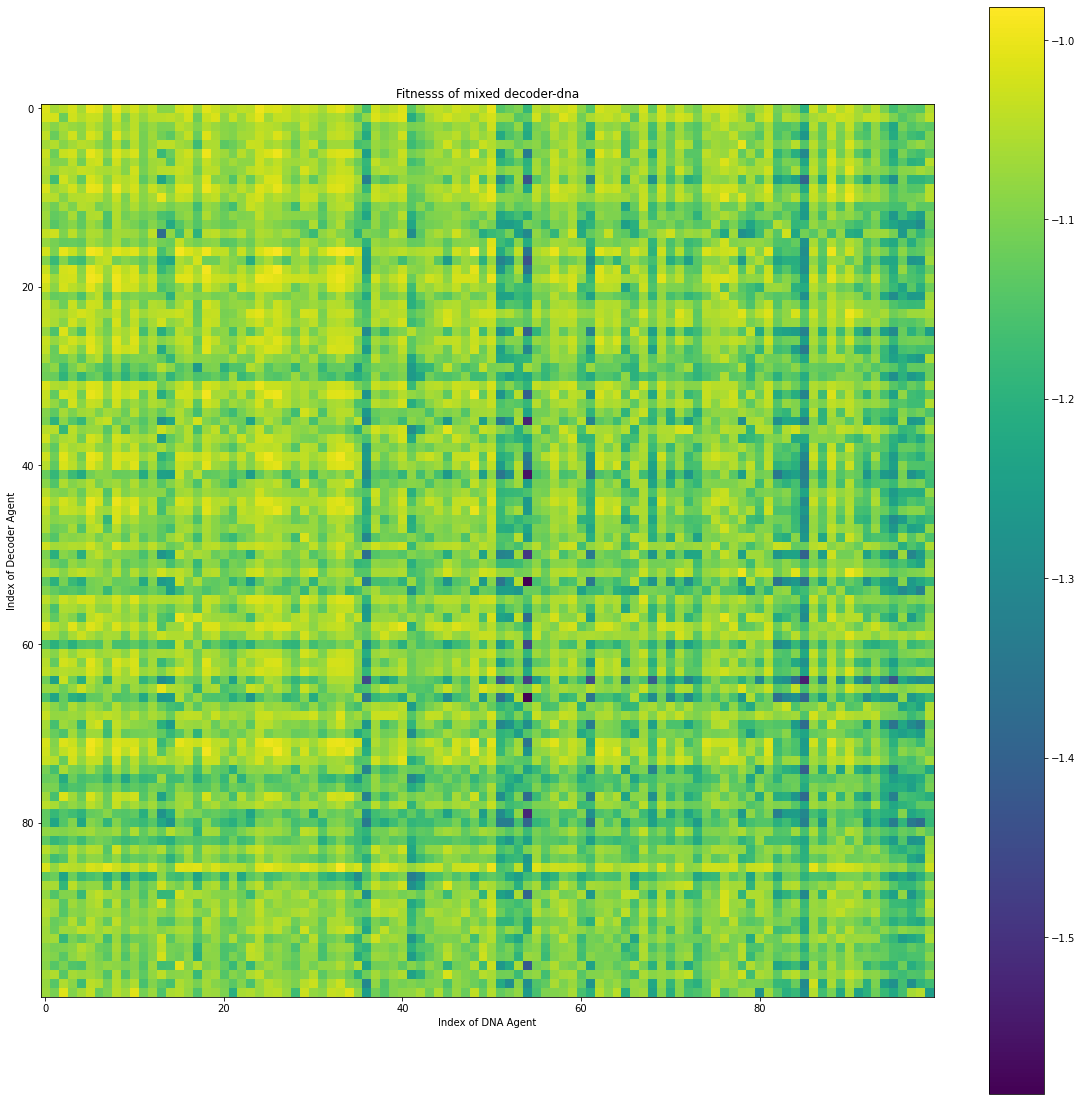

In [236]:
plt.figure(figsize=(20,20))
plt.imshow(fit)
plt.title('Fitnesss of mixed decoder-dna');plt.ylabel('Index of Decoder Agent');plt.xlabel('Index of DNA Agent')
plt.colorbar()

In [229]:
gen_idx = 999
# plt.figure(figsize=(20,20))
config = torch.load(os.path.join(logger.log_dir, 'config'))
pop = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
fitnesses = torch.load(os.path.join(logger.log_dir, f'fitnesses_gen_{gen_idx:05d}'))

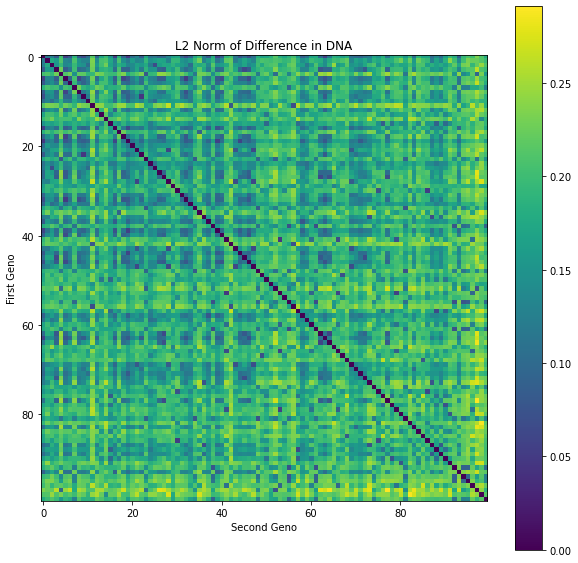

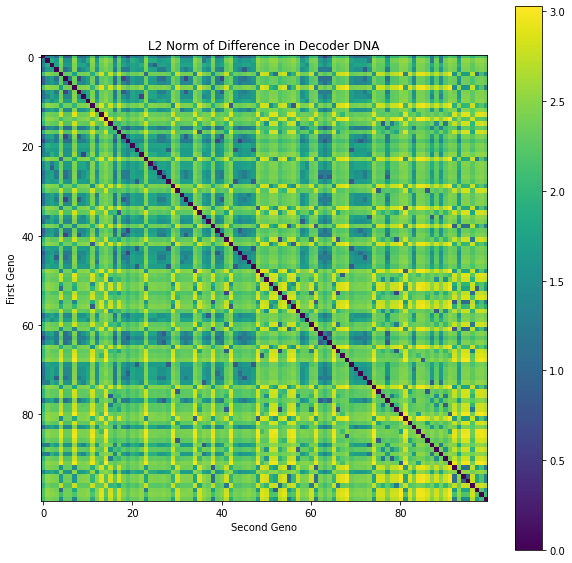

In [230]:
def show_dna_diff(pop):
    a = torch.stack([geno.dna for geno in pop])
    l2_dist = (a[:, None, :] - a[None, :, :]).norm(dim=-1)
    plt.figure(figsize=(10,10));plt.imshow(l2_dist.detach().cpu().numpy());plt.colorbar()
    plt.title('L2 Norm of Difference in DNA');plt.ylabel('First Geno');plt.xlabel('Second Geno')
    
def show_decoder_dna_diff(pop):
    a = torch.stack([geno.decoder_dna for geno in pop])
    l2_dist = (a[:, None, :] - a[None, :, :]).norm(dim=-1)
    plt.figure(figsize=(10,10));plt.imshow(l2_dist.detach().cpu().numpy());plt.colorbar()
    plt.title('L2 Norm of Difference in Decoder DNA');plt.ylabel('First Geno');plt.xlabel('Second Geno')
    
show_dna_diff(pop)
show_decoder_dna_diff(pop)

# Evolution of DNA

In [208]:
fit = np.zeros((1000, len(pop)))
for gen_idx in tqdm(range(1000)):
    pop_ = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
    
    for i, geno in enumerate(pop_):
        pheno = to_pheno_mix_match_dna_and_decoder(pop[0], geno, decoder, pheno)
        fit[gen_idx, i] = calc_pheo_fitness(pheno)['fitness']

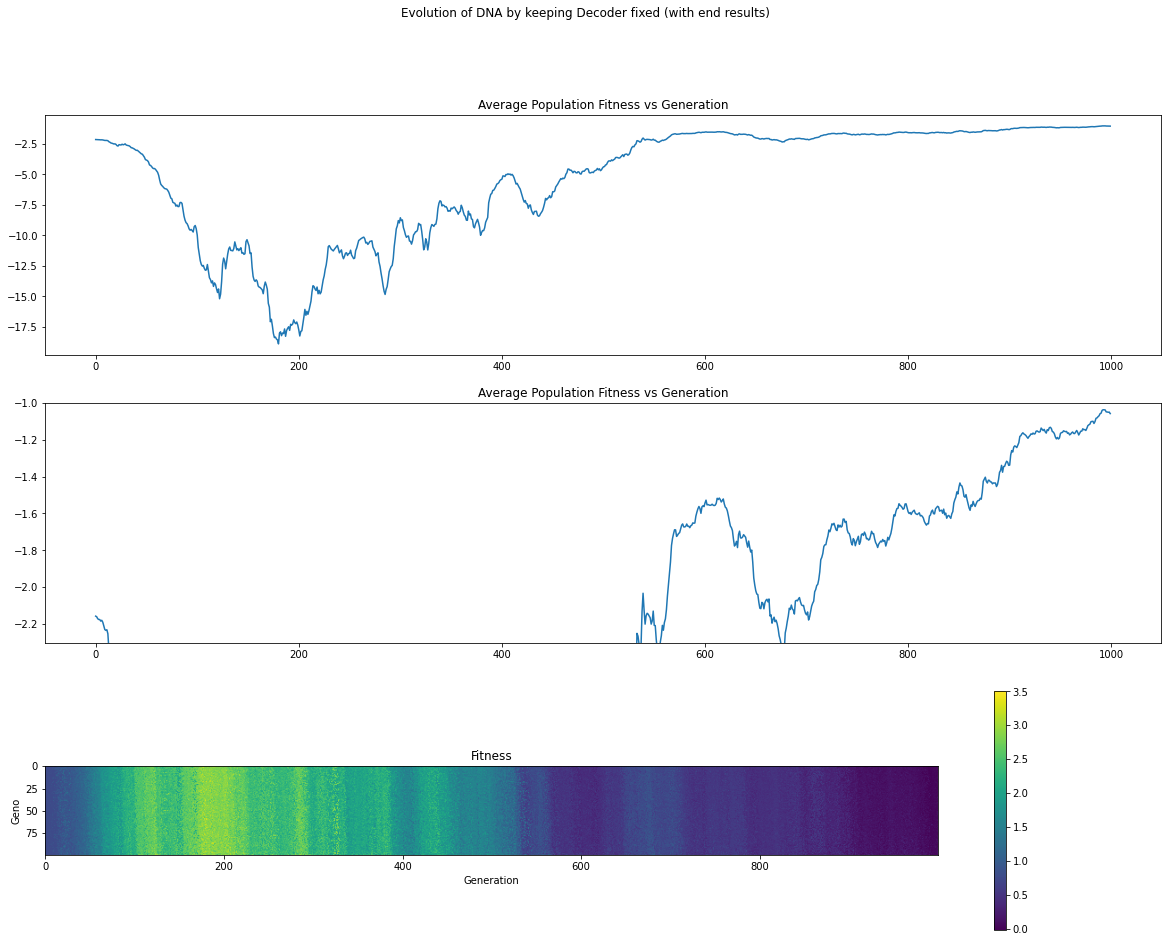

In [209]:
plt.figure(figsize=(20,15))
plt.suptitle('Evolution of DNA by keeping Decoder fixed (with end results)')
plt.subplot(311)
plt.errorbar(np.arange(len(fit)), fit.mean(axis=-1), yerr=fit.std(axis=-1), elinewidth=0.5)
plt.title('Average Population Fitness vs Generation')
plt.subplot(312)
plt.errorbar(np.arange(len(fit)), fit.mean(axis=-1), yerr=fit.std(axis=-1), elinewidth=0.5)
plt.ylim(-2.3, -1)
plt.title('Average Population Fitness vs Generation')
plt.subplot(313)
plt.imshow(np.log(np.abs(fit.T)))
plt.colorbar()
plt.title('Fitness');plt.ylabel('Geno');plt.xlabel('Generation')
plt.show()

# Evolution of Decoders

In [210]:
fit = np.zeros((1000, len(pop)))
for gen_idx in tqdm(range(1000)):
    pop_ = torch.load(os.path.join(logger.log_dir, f'pop_gen_{gen_idx:05d}'))
    
    for i, geno in enumerate(pop_):
        pheno = to_pheno_mix_match_dna_and_decoder(geno, pop[0], decoder, pheno)
        fit[gen_idx, i] = calc_pheo_fitness(pheno)['fitness']

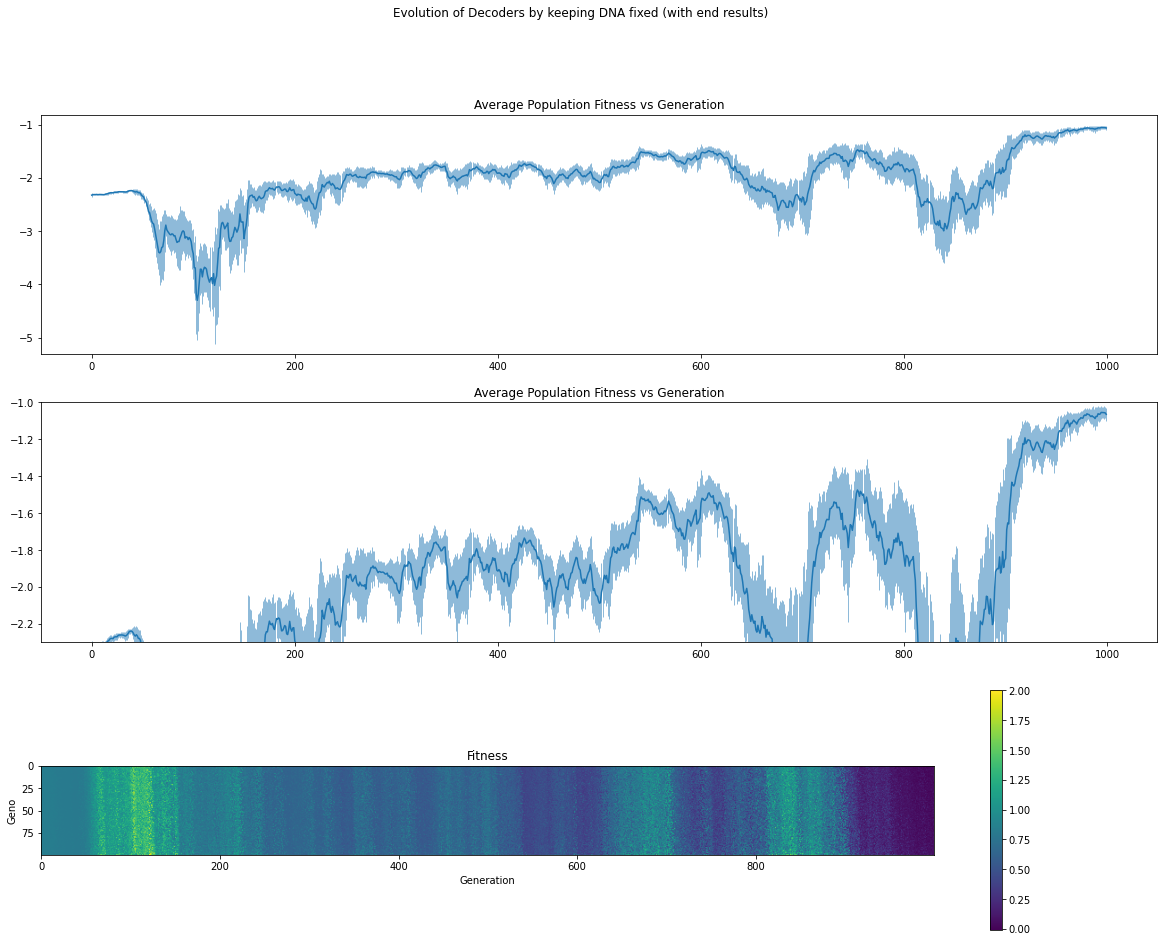

In [222]:
plt.figure(figsize=(20,15))
plt.suptitle('Evolution of Decoders by keeping DNA fixed (with end results)')
plt.subplot(311)
plt.errorbar(np.arange(len(fit)), fit.mean(axis=-1), yerr=fit.std(axis=-1), elinewidth=0.5)
plt.title('Average Population Fitness vs Generation')
plt.subplot(312)
plt.errorbar(np.arange(len(fit)), fit.mean(axis=-1), yerr=fit.std(axis=-1), elinewidth=0.5)
plt.ylim(-2.3, -1)
plt.title('Average Population Fitness vs Generation')
plt.subplot(313)
plt.imshow(np.log(np.abs(fit.T)))
plt.colorbar()
plt.title('Fitness');plt.ylabel('Geno');plt.xlabel('Generation')
plt.show()